In [87]:
import os
import dill, sys
import copy
import numpy as np
import matplotlib.pyplot as plt

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress

from astropy.io import fits
import astropy.wcs as wcs
import astropy.units as u
from astropy.table import Table, Column, Row, vstack, hstack
from astropy.coordinates import SkyCoord


import pickle

In [88]:
from astropy.visualization import lupton_rgb

In [89]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=15)

In [94]:
obj_cat = Table.read('/tigress/jiaxuanl/public_html/galary/catalogs/magellan_proposal/udg_July22_bright_large.txt',
                     format='ascii')[4:-1]

### Get HSC images

In [95]:
obj_cat

viz-id,ra,dec,rhalf_spergel,SB_eff_avg_g
str11,float64,float64,float64,float64
40777,337.3076356,-1.2152801,2.976255456741576,25.09564252464412
82230,340.1742102,3.1779487,2.845967979569235,25.434926596139878
79982,346.2485375,1.8339379,7.175533465782251,25.011417066247954
21534,350.35837,0.4649426,3.1386007559298728,25.0221527172495
75212,32.2729832,-6.3073727,4.031836932045927,25.143687382016545
75570,32.7693748,-2.9838995,2.9691266933281915,24.91722084607033
45406,35.3498461,-5.3589374,2.6624316889367865,25.20655859500249
86749,35.4086987,-5.4419486,5.367105096100613,25.05920104522433


In [96]:
from unagi import config
from unagi import hsc
from unagi.task import hsc_cutout

pdr2 = hsc.Hsc(dr='pdr2', rerun='pdr2_wide')

# Get table list from /home/jiaxuanl/.local/lib/python3.10/site-packages/unagi-0.1.3.dev19-py3.10.egg/unagi/data/pdr2_wide/pdr2_wide_tables.fits


In [76]:
for obj in obj_cat[2:]:

    coord = SkyCoord(obj['ra'], obj['dec'], frame='icrs', unit='deg')

    # Angular size
    s_ang = 3 * u.arcmin

    # Filters
    filters = 'griz'

    for filt in filters:
        cutout_test = hsc_cutout(coord, cutout_size=s_ang, filters=filt, 
                                 archive=pdr2, use_saved=False, output_dir='./Cutout/magellan_proposal/', 
                                 verbose=True, prefix=obj['viz-id'],
                                 save_output=True, image=True, mask=False, variance=False)

# Retrieving cutout image in filter: g
# Retrieving cutout image in filter: r
# Retrieving cutout image in filter: i
# Retrieving cutout image in filter: z
# Retrieving cutout image in filter: g
# Retrieving cutout image in filter: r
# Retrieving cutout image in filter: i
# Retrieving cutout image in filter: z
# Retrieving cutout image in filter: g
# Retrieving cutout image in filter: r
# Retrieving cutout image in filter: i
# Retrieving cutout image in filter: z
# Retrieving cutout image in filter: g
# Retrieving cutout image in filter: r
# Retrieving cutout image in filter: i
# Retrieving cutout image in filter: z
# Retrieving cutout image in filter: g
# Retrieving cutout image in filter: r
# Retrieving cutout image in filter: i
# Retrieving cutout image in filter: z
# Retrieving cutout image in filter: g
# Retrieving cutout image in filter: r
# Retrieving cutout image in filter: i
# Retrieving cutout image in filter: z


In [56]:
from kuaizi.utils import img_cutout

## Finder charts

In [57]:
offsets = Table.read(
    '/home/jiaxuanl/Research/Packages/kuaizi/diezi/scarlet_modeling/magellan_proposal/offset_stars.txt', 
    format='ascii')

In [58]:
import matplotlib.patches as patches
import scarlet

In [60]:
from scarlet.display import AsinhMapping

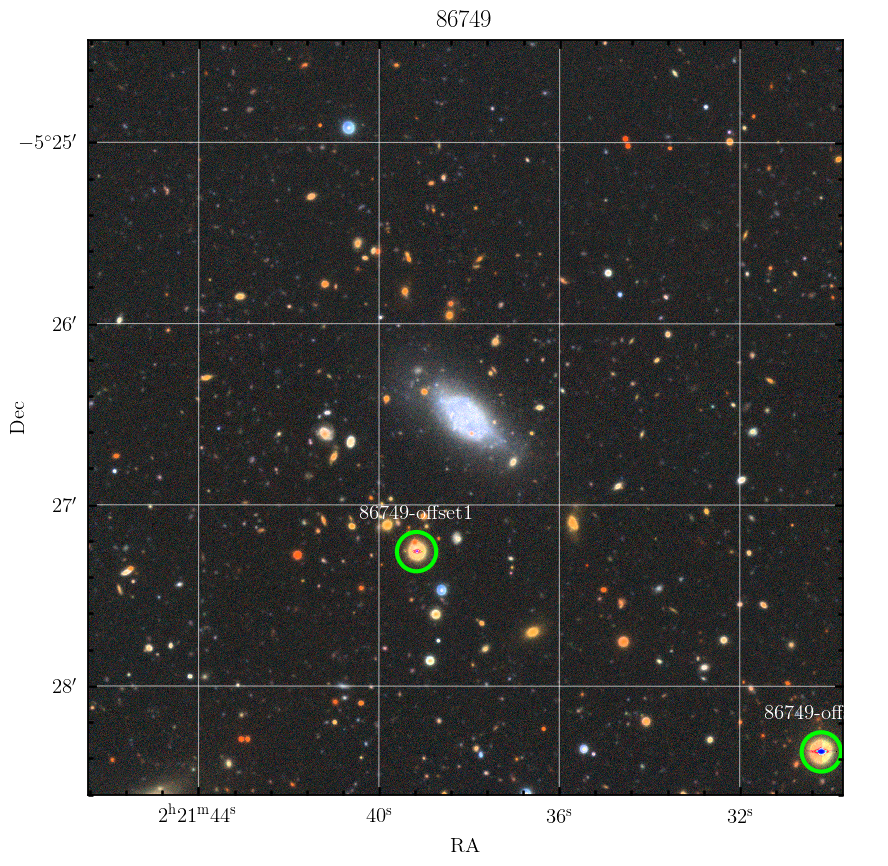

In [82]:
for obj in obj_cat[7:8]:
    size = 250
    griz = []

    for filt in list('griz'):
        hdu = fits.open(f'./Cutout/magellan_proposal/{obj["viz-id"]}_{filt}.fits')
        w = wcs.WCS(hdu[1].header)
        temp = img_cutout(hdu[1].data, w, 
                   obj['ra'], obj['dec'], size=(size, size), pixel_unit=False, pixel_scale=0.168)
        griz.append(temp[0].data)
        hdu.close()
    norm = AsinhMapping(minimum=-0.15, stretch=1, Q=1.5)
    img_rgb = scarlet.display.img_to_rgb(
        np.array(griz), norm=norm, channel_map=channel_map)

    f = plt.figure(figsize=(10, 10))
    w = wcs.WCS(temp[2])
    ax = plt.subplot(projection=w)
    plt.imshow(img_rgb, origin='lower')
    
    # Create a Rectangle patch
    for star in offsets[[obj['viz-id'] in item for item in offsets['viz-id'].data]]:
        x, y = w.wcs_world2pix(star['ra'], star['dec'], 0)
#         rect = patches.Rectangle((800, 200), 50, 50, linewidth=4, 
#                                  edgecolor='g', facecolor='none',
#                                  transform=ax.get_transform('fk5'))
#         ax.add_patch(rect)
        ax.scatter(star['ra'], star['dec'], transform=ax.get_transform('fk5'), 
                   s=800, lw=3, edgecolor='lime', facecolor='none')
        ax.text(star['ra'], star['dec'] + 0.003, star['viz-id'], ha='center', color='w',
                transform=ax.get_transform('fk5'))
        
    plt.grid(color='white', ls='solid')
    plt.xlabel('RA')
    plt.ylabel('Dec', labelpad=0)
    plt.title(obj["viz-id"])
# # #     plt.axis('off')
    plt.savefig(f'/tigress/jiaxuanl/public_html/galary/catalogs/magellan_proposal/{obj["viz-id"]}_finder.png', 
                bbox_inches='tight')
#     plt.close()

In [84]:
img_rgb.shape

(1488, 1488, 3)

In [83]:
for obj in obj_cat:
    print(f'<img src="./catalogs/magellan_proposal/{obj["viz-id"]}_finder.png" width="600">')

<img src="./catalogs/magellan_proposal/40777_finder.png" width="600">
<img src="./catalogs/magellan_proposal/82230_finder.png" width="600">
<img src="./catalogs/magellan_proposal/79982_finder.png" width="600">
<img src="./catalogs/magellan_proposal/21534_finder.png" width="600">
<img src="./catalogs/magellan_proposal/75212_finder.png" width="600">
<img src="./catalogs/magellan_proposal/75570_finder.png" width="600">
<img src="./catalogs/magellan_proposal/45406_finder.png" width="600">
<img src="./catalogs/magellan_proposal/86749_finder.png" width="600">


### Blind offset

In [111]:
obscat = Table.read(
    '/tigress/jiaxuanl/public_html/galary/catalogs/magellan_proposal/udg_July22_bright_large.txt', 
    format='ascii')

refstars = Table.read(
    '/home/jiaxuanl/Research/Packages/kuaizi/diezi/scarlet_modeling/magellan_proposal/refstars.txt', 
    format='ascii')

In [112]:
for obj in obscat[1:-1]:
    _star = refstars[[obj['viz-id'] in name for name in refstars['viz-id']]]

    galaxy = SkyCoord(obj['ra'], obj['dec'], unit='deg')
    star = SkyCoord(_star['ra'], _star['dec'], unit='deg')
    
    dra, ddec = star.spherical_offsets_to(galaxy)
    print(obj['viz-id'], dra.to(u.arcsec), ddec.to(u.arcsec))

dw1859m6402 [-5.88283arcsec] [-15.7743arcsec]
dw1903m6405 [-6.45084arcsec] [-2.79201arcsec]
dw1912m6432 [-17.0188arcsec] [-7.95063arcsec]
40777 [3.3674arcsec] [-15.7684arcsec]
82230 [12.9767arcsec] [-1.98466arcsec]
79982 [-47.3607arcsec 40.4343arcsec] [-10.3034arcsec -11.7434arcsec]
21534 [-27.1071arcsec] [-9.56663arcsec]
75212 [-45.1455arcsec] [-17.5423arcsec]
75570 [-19.5042arcsec] [-30.5982arcsec]
45406 [18.0866arcsec] [-19.2147arcsec]
86749 [-5.38032arcsec -16.1316arcsec] [-33.655arcsec 44.465arcsec]


In [113]:
obj_cat = obscat[4:-1]

79982 -47.3607arcsec -10.3034arcsec
79982 40.4343arcsec -11.7434arcsec


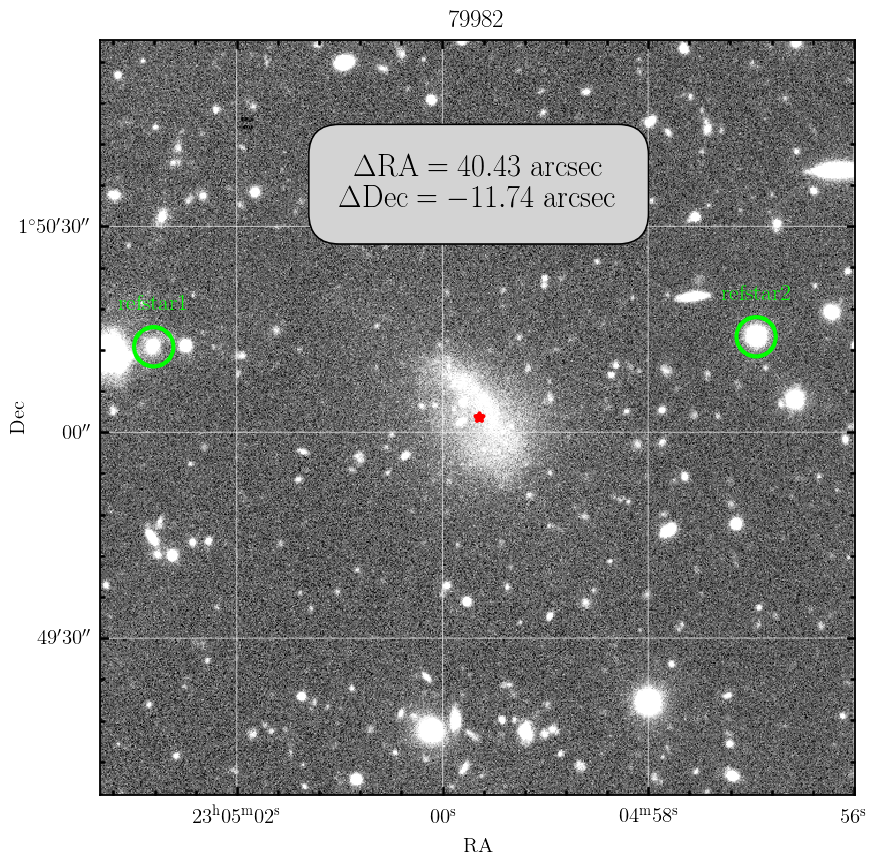

In [115]:
offsets = Table.read(
    '/home/jiaxuanl/Research/Packages/kuaizi/diezi/scarlet_modeling/magellan_proposal/refstars.txt', 
    format='ascii')

for obj in obj_cat[2:3]:
    size = 110
    griz = []
    
    for filt in list('griz'):
        hdu = fits.open(f'./Cutout/magellan_proposal/{obj["viz-id"]}_{filt}.fits')
        w = wcs.WCS(hdu[1].header)
        temp = img_cutout(hdu[1].data, w, 
                   obj['ra'], obj['dec'], size=(size, size), pixel_unit=False, pixel_scale=0.168)
        griz.append(temp[0].data)
        hdu.close()

    f = plt.figure(figsize=(10, 10))
    w = wcs.WCS(temp[2])
    ax = plt.subplot(projection=w)
    try:
        ax = display_single(griz[2], cmap='Greys_r', ax=ax)
    except:
        pass
    
    # show object
    ax.scatter(obj['ra'], obj['dec'], transform=ax.get_transform('fk5'), 
                   marker='*', lw=3, edgecolor='red', facecolor='red')
    
    for star in offsets[[obj['viz-id'] in item for item in offsets['viz-id'].data]]:
        
        gal_corr = SkyCoord(obj['ra'], obj['dec'], unit='deg')
        star_corr = SkyCoord(star['ra'], star['dec'], unit='deg')

        dra, ddec = star_corr.spherical_offsets_to(gal_corr)
        print(obj['viz-id'], dra.to(u.arcsec), ddec.to(u.arcsec))
    
        x, y = w.wcs_world2pix(star['ra'], star['dec'], 0)
#         rect = patches.Rectangle((800, 200), 50, 50, linewidth=4, 
#                                  edgecolor='g', facecolor='none',
#                                  transform=ax.get_transform('fk5'))
#         ax.add_patch(rect)
        ax.scatter(star['ra'], star['dec'], transform=ax.get_transform('fk5'), 
                   s=800, lw=3, edgecolor='lime', facecolor='none')
    
        ax.text(star['ra'], star['dec'] + 0.0015, star['viz-id'].lstrip(obj["viz-id"] + '-'), 
                ha='center', color='lime',
                transform=ax.get_transform('fk5'), fontsize=17)
        
        ax.text(obj['ra'] - 0.000, obj['dec'] + 0.0085, 
                r'$\Delta\mathrm{RA}=' + f'{dra.to(u.arcsec).value:.2f}' + r'\ \rm{arcsec}$' + '\n' + r'$\Delta\mathrm{Dec}=' + f'{ddec.to(u.arcsec).value:.2f}' + r'\ \rm{arcsec}$', 
                ha='center', color='k', fontweight='bold',
                transform=ax.get_transform('fk5'), fontsize=22,
                bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=1'))
        
    
    plt.grid(color='white', ls='solid')
    plt.xlabel('RA')
    plt.ylabel('Dec', labelpad=0)
    plt.title(obj["viz-id"])
#     plt.savefig(f'/tigress/jiaxuanl/public_html/galary/catalogs/magellan_proposal/{obj["viz-id"]}_refstar_offset.png', 
#                 bbox_inches='tight')
#     plt.close()